In [20]:
from pyspark.sql import SparkSession
from pyspark import SparkContext
from pyspark.sql import functions as F
from pyspark.sql.functions import hour
import matplotlib.pyplot as plt
import requests
from bs4 import BeautifulSoup
import datetime

In [3]:
if SparkContext._active_spark_context:
    SparkContext._active_spark_context.stop()

spark = SparkSession.builder \
        .appName("NYC Taxi Analysis") \
        .config("spark.driver.bindAddress", "127.0.0.1") \
        .getOrCreate()

## Data Loading

In [4]:
# 2023년, 2024년 데이터

In [8]:
df = spark.read.parquet("data/yellow_tripdata_2023-12.parquet")

In [17]:
df

DataFrame[VendorID: int, tpep_pickup_datetime: timestamp_ntz, tpep_dropoff_datetime: timestamp_ntz, passenger_count: bigint, trip_distance: double, RatecodeID: bigint, store_and_fwd_flag: string, PULocationID: int, DOLocationID: int, payment_type: bigint, fare_amount: double, extra: double, mta_tax: double, tip_amount: double, tolls_amount: double, improvement_surcharge: double, total_amount: double, congestion_surcharge: double, Airport_fee: double, hour: int]

## Data Cleaning

### 결측치 제거

In [10]:
df.count()

3376567

In [13]:
df = df.dropna()

In [14]:
df.count()

3196564

### 비정상적인 값(음수의 여행시간 또는 거리) 필터링

In [35]:
# 음수의 거리를 움직인 행의 개수
df[df['trip_distance'] < 0].count()

0

In [36]:
# 택시 탑승 시간 계산
df = df.withColumn(
    "trip_duration",
    (F.unix_timestamp("tpep_dropoff_datetime") - F.unix_timestamp("tpep_pickup_datetime"))
)

In [37]:
df[df['trip_duration'] < 0].count()

869

In [38]:
df = df.filter(df['trip_duration'] >= 0)
df.count()

3271826

## Calculation of Metrics

In [57]:
# Calculate the average trip duration
avg_trip_duration = df.agg({"trip_duration": "avg"}).collect()[0][0]
print(f"Average Trip Duration: {avg_trip_duration} sec")

Average Trip Duration: 1065.5371566214096 sec


In [59]:
# Calculate the average trip distance
avg_trip_distance = df.agg({"trip_distance": "avg"}).collect()[0][0]
print(f"Average Trip Distance: {avg_trip_distance} km")

Average Trip Distance: 3.3046252429070293 km


## Peak Hours Identification

+----+------+
|hour| count|
+----+------+
|  18|219019|
|  17|212499|
|  15|206571|
|  16|201390|
|  19|199934|
|  14|197899|
|  13|186067|
|  20|181298|
|  21|180552|
|  12|180220|
|  22|167224|
|  11|164132|
|  10|149146|
|  23|135552|
|   9|129962|
|   8|107261|
|   0| 97059|
|   7| 76178|
|   1| 64345|
|   2| 42197|
+----+------+
only showing top 20 rows



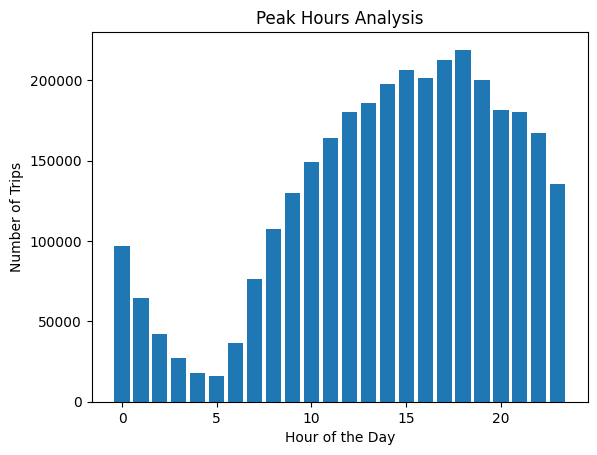

In [16]:
# Identify the peak hours for taxi usage.
df = df.withColumn("hour", hour("tpep_pickup_datetime"))
peak_hours = df.groupBy("hour").count().orderBy("count", ascending=False)
peak_hours.show()

peak_hours_pd = peak_hours.toPandas()
plt.bar(peak_hours_pd['hour'], peak_hours_pd['count'])
plt.xlabel('Hour of the Day')
plt.ylabel('Number of Trips')
plt.title('Peak Hours Analysis')
plt.savefig("peak_hours_plot.png")
plt.show()

## Weather Condition Analysis

In [32]:
# Analyze the effect of weather conditions on taxi demand. 
# Use additional datasets if necessary to obtain weather information for the corresponding time periods.

def getNewyorkData():
    base_url = 'https://www.wunderground.com/history/daily/us/ny/new-york-city/KLGA/date/'
    start_date = datetime.date(2023,1,1)
    end_date = datetime.date(2023,1,2)
    now_date = start_date
    while now_date <= end_date:
        url = base_url + str(now_date)
        response = requests.get(url)
        if response.status_code == 200:
            html = response.text 
            soup = BeautifulSoup(html, 'html.parser')
            table = soup.select("div.region-content-main > div.row > div:nth-child(5) > div:nth-child(1) > div > lib-city-history-observation > div > div.observation-table.ng-star-inserted > table > tbody")
            print(table)
        now_date = now_date + datetime.timedelta(days=1)
getNewyorkData()

[]
[]


## Output

In [71]:
# Todo : 계산된 지표와 분석 결과, 시각화된 그래프가 파일로 저장(CSV, Parquet)